In [ ]:
PATH_DRIVE = '/content/drive'
PATH_DRIVE_TP = PATH_DRIVE + '/MyDrive/TP_Datos_2C2021/parte_2'
PATH_DRIVE_TP_PREDICCIONES = PATH_DRIVE_TP + '/predicciones'

KNN_IMPUTER_COMPUTAR = False
KNN_IMPUTER_PATH_VALUES = PATH_DRIVE_TP + '/imputaciones/hamburguesas_values_knn.csv'
KNN_IMPUTER_PATH_VAL_DEV = PATH_DRIVE_TP + '/imputaciones/hamburguesas_val_dev_knn.csv'
KNN_IMPUTER_PATH_TEST = PATH_DRIVE_TP + '/imputaciones/hamburguesas_test_knn.csv'

In [ ]:
from google.colab import drive
import sys

drive.mount(PATH_DRIVE, force_remount=True)
sys.path.insert(0, PATH_DRIVE_TP)

Mounted at /content/drive


In [ ]:
!pip install category_encoders

from preprocessing import *

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Librerías de métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# haciendo los graficos un poco mas bonitos en matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['figure.dpi'] = 150

# seteando tipo de grid en seaborn
sns.set_theme(style='ticks', palette=None, font_scale=.9) 

In [ ]:
VALUES_URL = 'https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs'
TARGET_URL = 'https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs'
TEST_URL = 'https://docs.google.com/spreadsheets/d/1mR_JNN0-ceiB5qV42Ff9hznz0HtWaoPF3B9zNGoNPY8'

hamburguesas_values, hamburguesas_target, hamburguesas_test = descargar_datasets(
    VALUES_URL, 
    TARGET_URL, 
    TEST_URL
)

In [ ]:
#Split en mi dataset de train y mi dataset de test
X_train, X_test, y_train, y_test = train_test_split(
    hamburguesas_values, 
    hamburguesas_target, 
    test_size=0.4,
    random_state=66, 
    stratify=hamburguesas_target.astype(str)
)

#Split en mi dataset de val_dev y test_holdout
X_val_dev, X_test_holdout, y_val_dev, y_test_holdout = train_test_split(
    X_test, 
    y_test, 
    test_size=0.1,
    random_state=66, 
    stratify=y_test.llovieron_hamburguesas_al_dia_siguiente.astype(str)
)

### Búsqueda de hiperparámetros del Modelo

In [ ]:
def computar_mejores_hiperparametros(model, hiperparametros, X_train, y_train):
  model_cv = GridSearchCV(
      estimator = model,
      param_grid = hiperparametros,
      scoring='roc_auc',
      cv=5, 
      verbose=3
  )

  model_cv.fit(X_train, y_train)

  return model_cv.best_params_

Armo el diccionario de hiperparámetros que vamos a buscar

In [ ]:
var_smoothing_range = np.logspace(0,-9, num=100)

hiperparametros_a_buscar = dict(
    var_smoothing = var_smoothing_range
)

### Funciones utiles para métricas

In [ ]:
def show_metrics_values(y_true, y_pred):
  valor_metrica = roc_auc_score(y_true, y_pred, average='micro')
  print(f'ROC AUC Score {valor_metrica}')
  
  valor_metrica = accuracy_score(y_true, y_pred)
  print(f'Accuracy Score {valor_metrica}')

  valor_metrica = precision_score(y_true, y_pred)
  print(f'Precision Score {valor_metrica}')

  valor_metrica = recall_score(y_true, y_pred)
  print(f'Recall Score {valor_metrica}')

  valor_metrica = f1_score(y_true, y_pred)
  print(f'F1 Score {valor_metrica}')
  

def plot_confusion_matrix(y_true, y_pred):
  names = sorted(set(y_true))
  cm = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cm, names, names)

  plt.figure(dpi=100)
  plt.title("Matriz de confusion")
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()


def plot_roc(_fpr, _tpr, x):
  roc_auc = auc(_fpr, _tpr)

  plt.figure(figsize=(12, 6), dpi=100)
  plt.plot(
      _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
  )
  plt.scatter(_fpr, x)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

## KnnImputer - Standar Scaler - One Hot Encoding con Hashing Trick

Hago el encoding de mis dataset

In [ ]:
#hamburguesas_train_values_ht = hashing_trick_ecoding(hamburguesas_values_escalado)
#hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'No': 0, 'Si': 1, np.NaN: 0})

#hamburguesas_val_dev_values_ht = hashing_trick_ecoding(hamburguesas_val_dev_escalado)
#hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'No': 0, 'Si': 1, np.NaN: 0})

hamburguesas_train_values_ht, hamburguesas_val_dev_values_ht, X_test_holdout_sn = preprocessing_knn_imputer_standar_escaler_one_hot_encoding_hashing_trick(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

In [ ]:
hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})

Busco los hiperparametros de mi modelo

In [ ]:
model = GaussianNB()

hiperparametros = computar_mejores_hiperparametros(
    model = model, 
    hiperparametros = hiperparametros_a_buscar, 
    X_train = hamburguesas_train_values_ht, 
    y_train = hamburguesas_train_target_enc
)

hiperparametros

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.825 total time=   0.2s
[CV 2/5] END .................var_smoothing=1.0;, score=0.824 total time=   0.2s
[CV 3/5] END .................var_smoothing=1.0;, score=0.826 total time=   0.2s
[CV 4/5] END .................var_smoothing=1.0;, score=0.825 total time=   0.2s
[CV 5/5] END .................var_smoothing=1.0;, score=0.828 total time=   0.2s
[CV 1/5] END ..var_smoothing=0.8111308307896871;, score=0.825 total time=   0.2s
[CV 2/5] END ..var_smoothing=0.8111308307896871;, score=0.823 total time=   0.2s
[CV 3/5] END ..var_smoothing=0.8111308307896871;, score=0.826 total time=   0.2s
[CV 4/5] END ..var_smoothing=0.8111308307896871;, score=0.824 total time=   0.2s
[CV 5/5] END ..var_smoothing=0.8111308307896871;, score=0.828 total time=   0.2s
[CV 1/5] END ...var_smoothing=0.657933224657568;, score=0.824 total time=   0.2s
[CV 2/5] END ...var_smoothing=0.65793322465756

{'var_smoothing': 1.0}

In [ ]:
modelo = GaussianNB(**hiperparametros)
modelo.fit(hamburguesas_train_values_ht, hamburguesas_train_target_enc)

GaussianNB(var_smoothing=1.0)

Obtengo las predicciones de mi modelo

In [ ]:
predictions = modelo.predict(hamburguesas_val_dev_values_ht)

#### Métricas del modelo

Los valores de las métricas mas usadas son los siguientes:

In [ ]:
show_metrics_values(hamburguesas_val_dev_target_enc, predictions)

ROC AUC Score 0.6794667077785911
Accuracy Score 0.8272742462941303
Precision Score 0.6685344072841884
Recall Score 0.416766728523087
F1 Score 0.5134480903711672


Veo la curva ROC, sabiendo que AUC es aproximadamente 0.70 segundo lo obtenido líneas arriba

array([0.        , 0.05783331, 1.        ])

array([0.        , 0.41676673, 1.        ])

array([2, 1, 0])

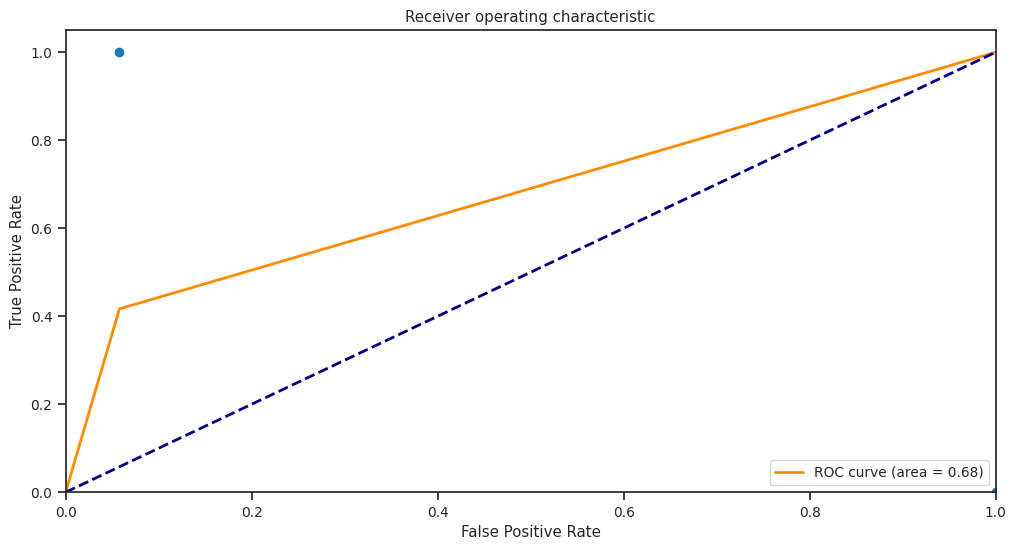

In [ ]:
fpr, tpr, thresholds = roc_curve(hamburguesas_val_dev_target_enc, predictions)

display(fpr)
display(tpr)
display(thresholds)

plot_roc(fpr, tpr, thresholds)

Vemos la matriz de confusión de nuestro modelo

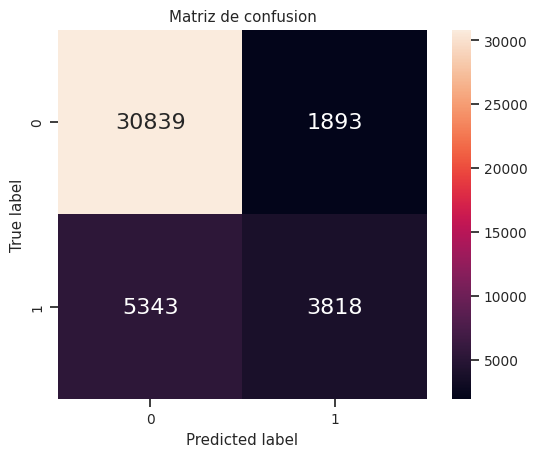

In [ ]:
plot_confusion_matrix(hamburguesas_val_dev_target_enc, predictions)

La matriz de confusion nos muestra nuestros $tp$ (verdaderos positivos, arriba a la izquierda), $fp$ (falsos positivos, abajo a la izquierda), $tn$ (verdaderos negativos, abajo a la derecha) y $fn$ (falsos negativos, arriba a la derecha) en una matriz.

En este caso, la tendencia del modelo es que tiende a predecir 0 sobre 1 porque si vemos la otra diagonal (la de "pifiadas") vemos que hay más casos de era 1 y lo predijo como 0, respecto de era 0 y lo predijo como 1. Por otro lado, la diagonal principal, es "saludable" pero no tanto, pues hay una diferencia muy alta entre los casos en los que era 0 y predijo 0 respecto de los de la otra diagonal pero no sucedió lo mismo en los casos en los que era 1 y predijo 1 (es bastante mayor que en era 0 y predijo 1 pero bastante menor que en era 1 y predijo 0). 

El modelo predijo bien más positivos (36182 casos, 86,37%) que negativos (5711 casos, 13,63%) porque hay una gran cantidad de verdaderos positivos y (en menor medida) falsos positivos, mientras que los verdaderos negativos y falsos negativos hay menos.

Guardamos las predicciones del modelo

In [ ]:
conversion_features_dataset(hamburguesas_test)

hamburguesas_test_sn = knn_imputer(None, None, None, hamburguesas_test, True)
hamburguesas_test_escalado = standar_scaler(hamburguesas_test_sn)
hamburguesas_test_sin_barrio = hashing_trick_encoding(hamburguesas_test_escalado)
hamburguesas_test_ht = one_hot_encoding(hamburguesas_test_sin_barrio)

predicciones = modelo.predict(hamburguesas_test_ht)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

nuestra_prediccion.to_csv(PATH_DRIVE_TP_PREDICCIONES + '/navie_bayes_knn_imputer_standar_scaler_ohe_ht.csv')

## KnnImputer - Standar Scaler - One Hot Encoding con Binary encoding

Hago el encoding de mis dataset

In [ ]:
hamburguesas_train_values_bin, hamburguesas_val_dev_values_bin, X_test_holdout_sn = preprocessing_knn_imputer_standar_escaler_one_hot_encoding_binary_encoding(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

In [ ]:
hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})

Busco los hiperparametros de mi modelo

In [ ]:
model = GaussianNB()

hiperparametros = computar_mejores_hiperparametros(
    model = model, 
    hiperparametros = hiperparametros_a_buscar, 
    X_train = hamburguesas_train_values_bin, 
    y_train = hamburguesas_train_target_enc
)

hiperparametros

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.825 total time=   0.2s
[CV 2/5] END .................var_smoothing=1.0;, score=0.824 total time=   0.2s
[CV 3/5] END .................var_smoothing=1.0;, score=0.826 total time=   0.2s
[CV 4/5] END .................var_smoothing=1.0;, score=0.825 total time=   0.2s
[CV 5/5] END .................var_smoothing=1.0;, score=0.828 total time=   0.2s
[CV 1/5] END ..var_smoothing=0.8111308307896871;, score=0.825 total time=   0.2s
[CV 2/5] END ..var_smoothing=0.8111308307896871;, score=0.823 total time=   0.2s
[CV 3/5] END ..var_smoothing=0.8111308307896871;, score=0.826 total time=   0.2s
[CV 4/5] END ..var_smoothing=0.8111308307896871;, score=0.824 total time=   0.2s
[CV 5/5] END ..var_smoothing=0.8111308307896871;, score=0.828 total time=   0.2s
[CV 1/5] END ...var_smoothing=0.657933224657568;, score=0.824 total time=   0.2s
[CV 2/5] END ...var_smoothing=0.65793322465756

{'var_smoothing': 1.0}

Dropeamos `barrio_4` de hamburguesas_train_values_bin para poder hacer la predicción porque esta sobrando luego de hacer el standar scaler:

In [ ]:
hamburguesas_train_values_bin.drop(labels='barrio_4', axis=1, inplace=True)

In [ ]:
modelo = GaussianNB(**hiperparametros)
modelo.fit(hamburguesas_train_values_bin, hamburguesas_train_target_enc)

GaussianNB(var_smoothing=1.0)

Obtengo las predicciones de mi modelo

In [ ]:
predictions = modelo.predict(hamburguesas_val_dev_values_bin)

#### Métricas del modelo

Los valores de las métricas mas usadas son los siguientes:

In [ ]:
show_metrics_values(hamburguesas_val_dev_target_enc, predictions)

ROC AUC Score 0.6783859406823204
Accuracy Score 0.827059413267133
Precision Score 0.6688998589562765
Recall Score 0.41414692719135465
F1 Score 0.5115620575743275


Veo la curva ROC, sabiendo que AUC es aproximadamente 0.71 segundo lo obtenido líneas arriba

array([0.        , 0.05737505, 1.        ])

array([0.        , 0.41414693, 1.        ])

array([2, 1, 0])

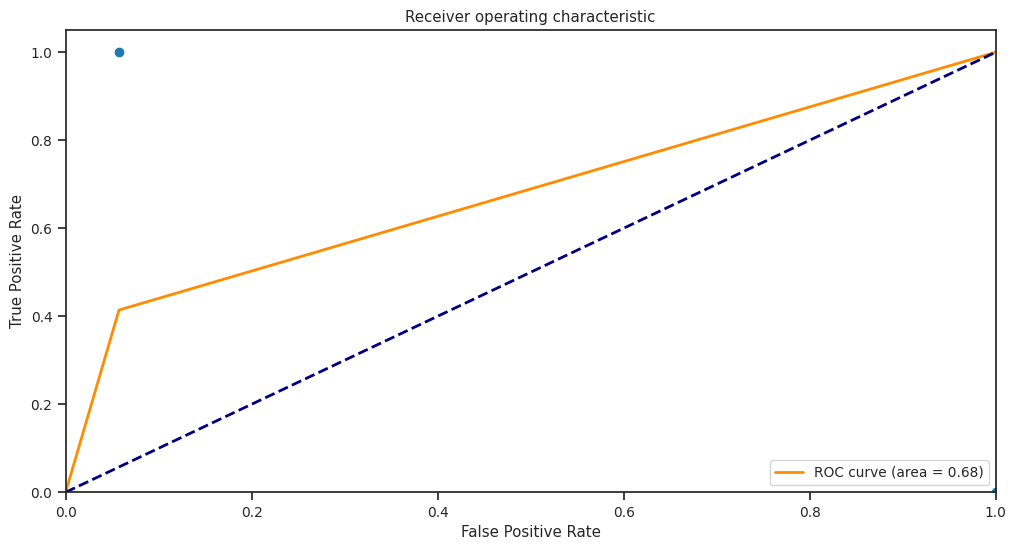

In [ ]:
fpr, tpr, thresholds = roc_curve(hamburguesas_val_dev_target_enc, predictions)

display(fpr)
display(tpr)
display(thresholds)

plot_roc(fpr, tpr, thresholds)

Vemos la matriz de confusión de nuestro modelo

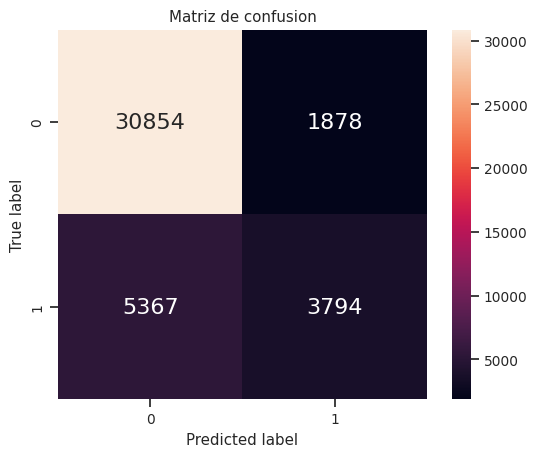

In [ ]:
plot_confusion_matrix(hamburguesas_val_dev_target_enc, predictions)

En este caso, la tendencia del modelo es que tiende a predecir 0 sobre 1 porque si vemos la otra diagonal (la de "pifiadas") vemos que hay más casos de era 1 y lo predijo como 0, respecto de era 0 y lo predijo como 1. Por otro lado, la diagonal principal, es "saludable" pero no tanto, pues hay una diferencia muy alta entre los casos en los que era 0 y predijo 0 respecto de los de la otra diagonal pero no sucedió lo mismo en los casos en los que era 1 y predijo 1 (es bastante mayor que en era 0 y predijo 1 pero bastante menor que en era 1 y predijo 0). 

El modelo predijo bien más positivos (36221 casos, 86,46%) que negativos (5672 casos, 13,54%) porque hay una gran cantidad de verdaderos positivos y (en menor medida) falsos positivos, mientras que los verdaderos negativos y falsos negativos hay menos.

Guardamos las predicciones del modelo

In [ ]:
conversion_features_dataset(hamburguesas_test)

hamburguesas_test_sn = knn_imputer(None, None, None, hamburguesas_test, True)
hamburguesas_test_escalado = standar_scaler(hamburguesas_test_sn)
hamburguesas_test_sin_barrio = binary_encoding(hamburguesas_test_escalado)
hamburguesas_test_bin = one_hot_encoding(hamburguesas_test_sin_barrio)

predicciones = modelo.predict(hamburguesas_test_bin)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

nuestra_prediccion.to_csv(PATH_DRIVE_TP_PREDICCIONES + '/navie_bayes_knn_imputer_standar_scaler_ohe_bin.csv')

## MeanImputer - Robust Scaler - One Hot Encoding con Binary encoding

Hago el encoding de mis dataset

In [ ]:
hamburguesas_train_values_bin, hamburguesas_val_dev_values_bin, X_test_holdout_sn = preprocessing_mean_imputer_robust_escaler_one_hot_encoding_binary_encoding(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

In [ ]:
hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})

Busco los hiperparametros de mi modelo

In [ ]:
model = GaussianNB()

hiperparametros = computar_mejores_hiperparametros(
    model = model, 
    hiperparametros = hiperparametros_a_buscar, 
    X_train = hamburguesas_train_values_bin, 
    y_train = hamburguesas_train_target_enc
)

hiperparametros

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.700 total time=   0.2s
[CV 2/5] END .................var_smoothing=1.0;, score=0.689 total time=   0.2s
[CV 3/5] END .................var_smoothing=1.0;, score=0.688 total time=   0.2s
[CV 4/5] END .................var_smoothing=1.0;, score=0.694 total time=   0.2s
[CV 5/5] END .................var_smoothing=1.0;, score=0.691 total time=   0.2s
[CV 1/5] END ..var_smoothing=0.8111308307896871;, score=0.703 total time=   0.2s
[CV 2/5] END ..var_smoothing=0.8111308307896871;, score=0.692 total time=   0.2s
[CV 3/5] END ..var_smoothing=0.8111308307896871;, score=0.691 total time=   0.2s
[CV 4/5] END ..var_smoothing=0.8111308307896871;, score=0.697 total time=   0.2s
[CV 5/5] END ..var_smoothing=0.8111308307896871;, score=0.694 total time=   0.2s
[CV 1/5] END ...var_smoothing=0.657933224657568;, score=0.706 total time=   0.2s
[CV 2/5] END ...var_smoothing=0.65793322465756

{'var_smoothing': 0.0002848035868435802}

In [ ]:
hamburguesas_train_values_bin.drop(labels='barrio_4', axis=1, inplace=True)

In [ ]:
modelo = GaussianNB(**hiperparametros)
modelo.fit(hamburguesas_train_values_bin, hamburguesas_train_target_enc)

GaussianNB(var_smoothing=0.0002848035868435802)

Obtengo las predicciones de mi modelo

In [ ]:
predictions = modelo.predict(hamburguesas_val_dev_values_bin)

#### Métricas del modelo

Los valores de las métricas mas usadas son los siguientes:

In [ ]:
show_metrics_values(hamburguesas_val_dev_target_enc, predictions)

ROC AUC Score 0.7067394570011127
Accuracy Score 0.81486167140095
Precision Score 0.58756076280693
Recall Score 0.5145726449077611
F1 Score 0.5486499068901304


Veo la curva ROC, sabiendo que AUC es aproximadamente 0.71 segundo lo obtenido líneas arriba

array([0.        , 0.10109373, 1.        ])

array([0.        , 0.51457264, 1.        ])

array([2, 1, 0])

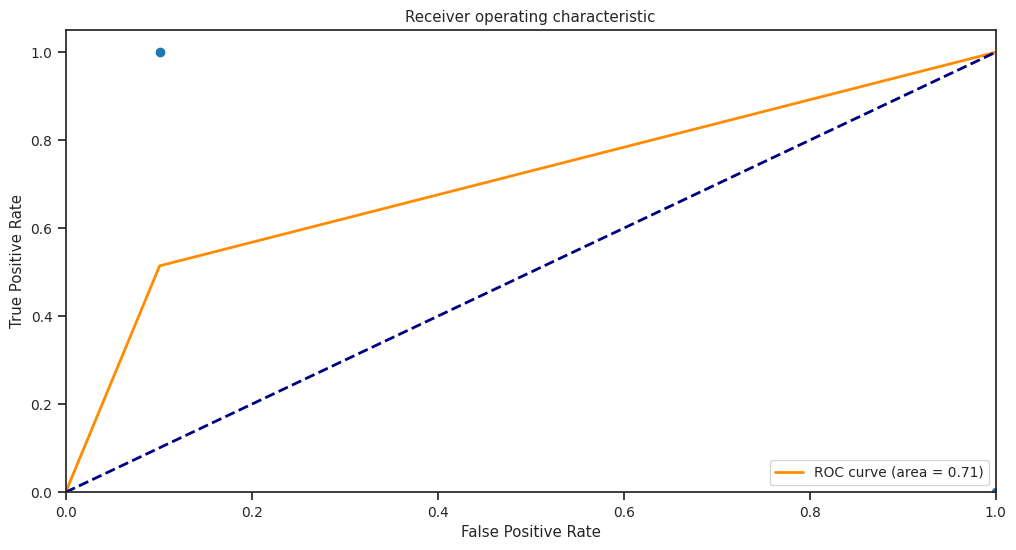

In [ ]:
fpr, tpr, thresholds = roc_curve(hamburguesas_val_dev_target_enc, predictions)

display(fpr)
display(tpr)
display(thresholds)

plot_roc(fpr, tpr, thresholds)

Vemos la matriz de confusión de nuestro modelo

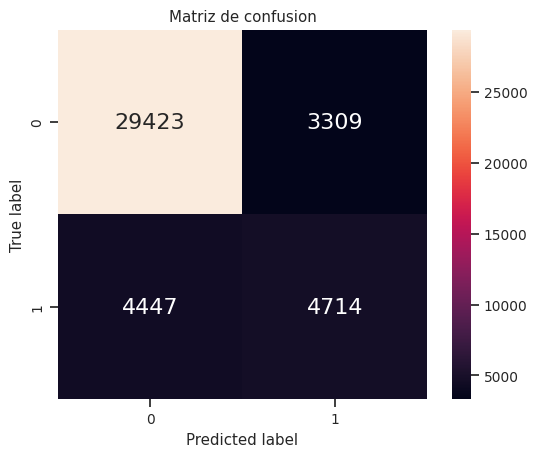

In [ ]:
plot_confusion_matrix(hamburguesas_val_dev_target_enc, predictions)

La matriz de confusion nos muestra nuestros $tp$ (verdaderos positivos), $fp$ (falsos positivos), $tn$ (verdaderos negativos) y $fn$ (falsos negativos) en una matriz. 
La diagonal principal son los valores correctamente clasificados, los otros valores indican la cantidad de puntos mal clasificados.

Guardamos las predicciones del modelo

In [ ]:
conversion_features_dataset(hamburguesas_test)

hamburguesas_test_sn = mean_imputer(None, None, None, hamburguesas_test, True)
hamburguesas_test_escalado = robust_scaler(hamburguesas_test_sn)
hamburguesas_test_sin_barrio = binary_encoding(hamburguesas_test_escalado)
hamburguesas_test_bin = one_hot_encoding(hamburguesas_test_sin_barrio)

predicciones = modelo.predict(hamburguesas_test_bin)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

nuestra_prediccion.to_csv(PATH_DRIVE_TP_PREDICCIONES + '/navie_bayes_mean_imputer_robust_scaler_ohe_ht.csv')